In [2]:
!pip install kaggle # 케글 데이터 설치

# kaggle.json 파일 코렙드라이브로 마운팅하기
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonum123","key":"c1ca2e09bb982a2d2b88a0f7f333377a"}'}

In [3]:
# 케글 파일 만들기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록
!chmod 600 ~/.kaggle/kaggle.json

# 케글 제이슨 파일 제대로 설치 됬는지 확인
!ls -lha kaggle.json # kaggle.json 이렇게 뜸

-rw-r--r-- 1 root root 64 May 15 03:13 kaggle.json


In [4]:
! kaggle competitions list

ref                                                                                deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-prize                 2024-06-27 23:59:00  Featured         $1,048,576        588           False  
https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability        2024-05-27 23:59:00  Featured           $105,000       3464           False  
https://www.kaggle.com/competitions/lmsys-chatbot-arena                            2024-08-05 23:59:00  Research           $100,000        254           False  
https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2  2024-07-02 23:59:00  Featured            $50,000       1381           False  
https://www.kaggle.com/competition

In [5]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

'''다운로드 성공시 표시됨
Downloading gtsrb-german-traffic-sign.zip to /content
 97% 594M/612M [00:03<00:00, 221MB/s]
100% 612M/612M [00:03<00:00, 207MB/s]
'''

!unzip gtsrb-german-traffic-sign.zip # zip 파일 풀기

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  inflating: train/

In [7]:
import pandas as pd
import numpy as np

import os
import pathlib

import cv2 #영상처리에 사용하는 오픈소스 라이브러리, 컴퓨터가 사람 눈처럼 인식할 수 있게 처리
from PIL import Image # 파이썬 이미지 처리 pillow 라이브러리
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator #imagedatagenerater는 이미지를 학습시킬 때 학습 데이터의 양이 적을 경우 학습데이터를 조금씩 변형 시켜서 학습데이터의 양을 늘리는 방식중 하나
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')#그래프 스타일 지정

#난수 랜덤성 고정
np.random.seed(42)

%matplotlib inline

In [8]:
# 코렙은 좌측 파일 아이콘 클릭해서 마운팅된 파일 하나를 오른쪽 마우스 클릭하면 경로 카피할 수 있음
data_dir = pathlib.Path('/content/Meta')
train_path = pathlib.Path('/content/Train')
test_path = pathlib.Path('/content/Test')

# 전처리: 이미지 별로 사이즈가 다르기 때문에 이미지의 폭과 높이를 같은 크기로 통일
IMG_HEGHT = 30
IMG_WIDTH = 30
channels = 3

# 카테고리 수 확인
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

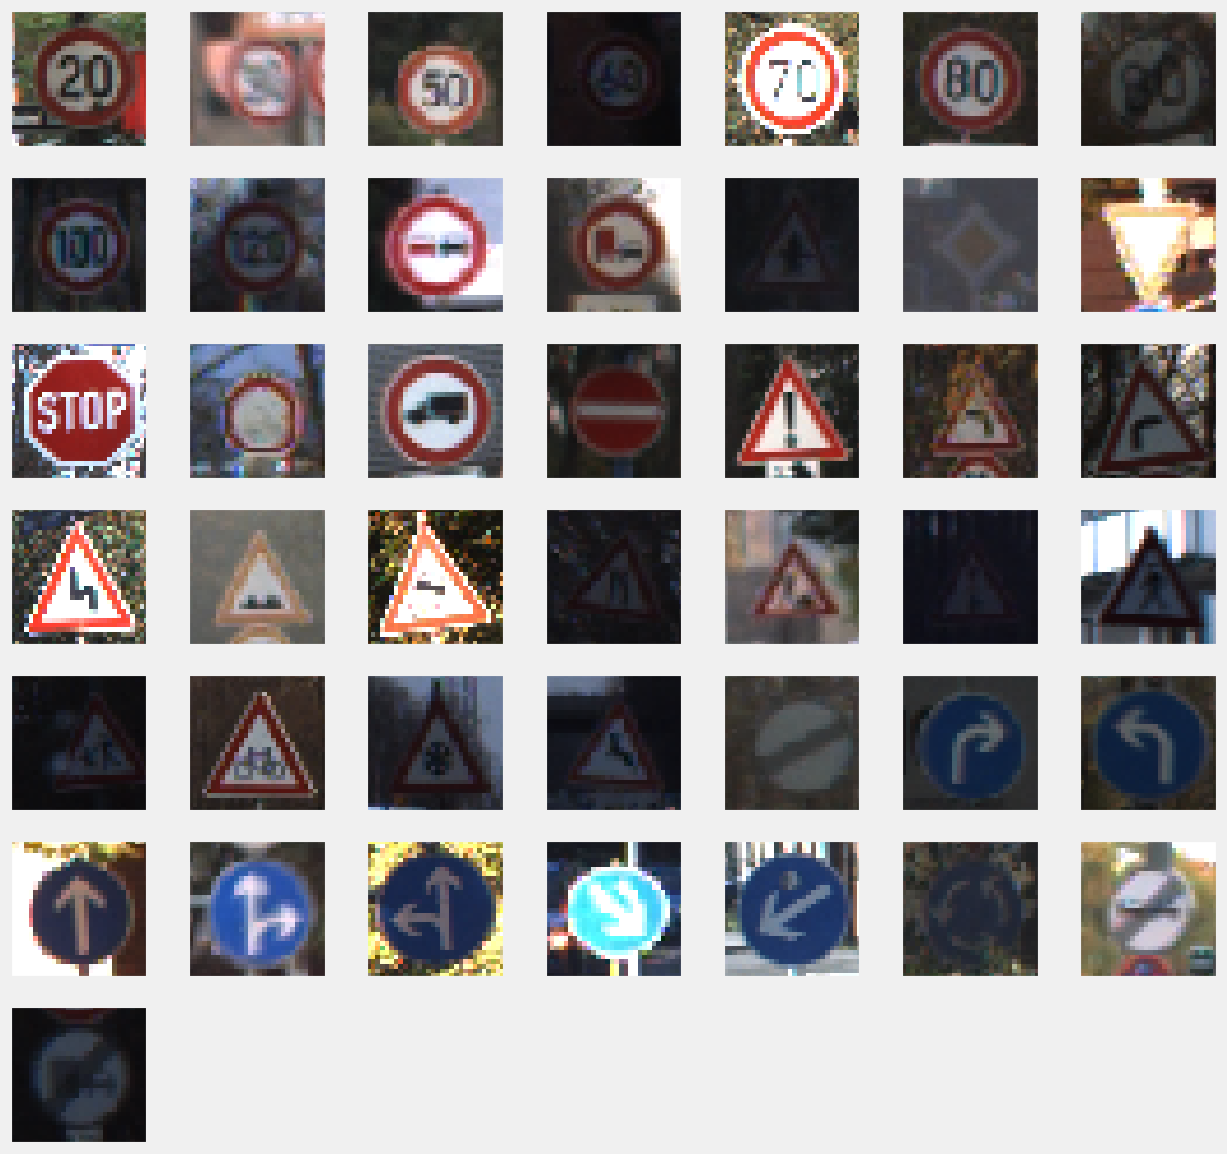

In [9]:
# 모든 교통표시판 시각화
# pathlib모듈을 사용하면, 파일, 디렉토리(폴더)의 경로를 객체로써 조작하거나 처리할 수 있다

img_dir = pathlib.Path('/content/train')
plt.figure(figsize=(14,14))
index = 0
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    plt.xticks([]) #눈금 설정 없음
    plt.yticks([])
    sign = list(img_dir.glob(f'{i}/*'))[0] #glob모듈의 glob함수는 사용자가 제시한 조건에 맞는 파일명을 리스트형식으로 반환 #*(아스터리스크)는 임의 길이의 모든 문자열을 의미
    img = load_img(sign, target_size=(30, 30))
    plt.imshow(img)
plt.show()

In [10]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

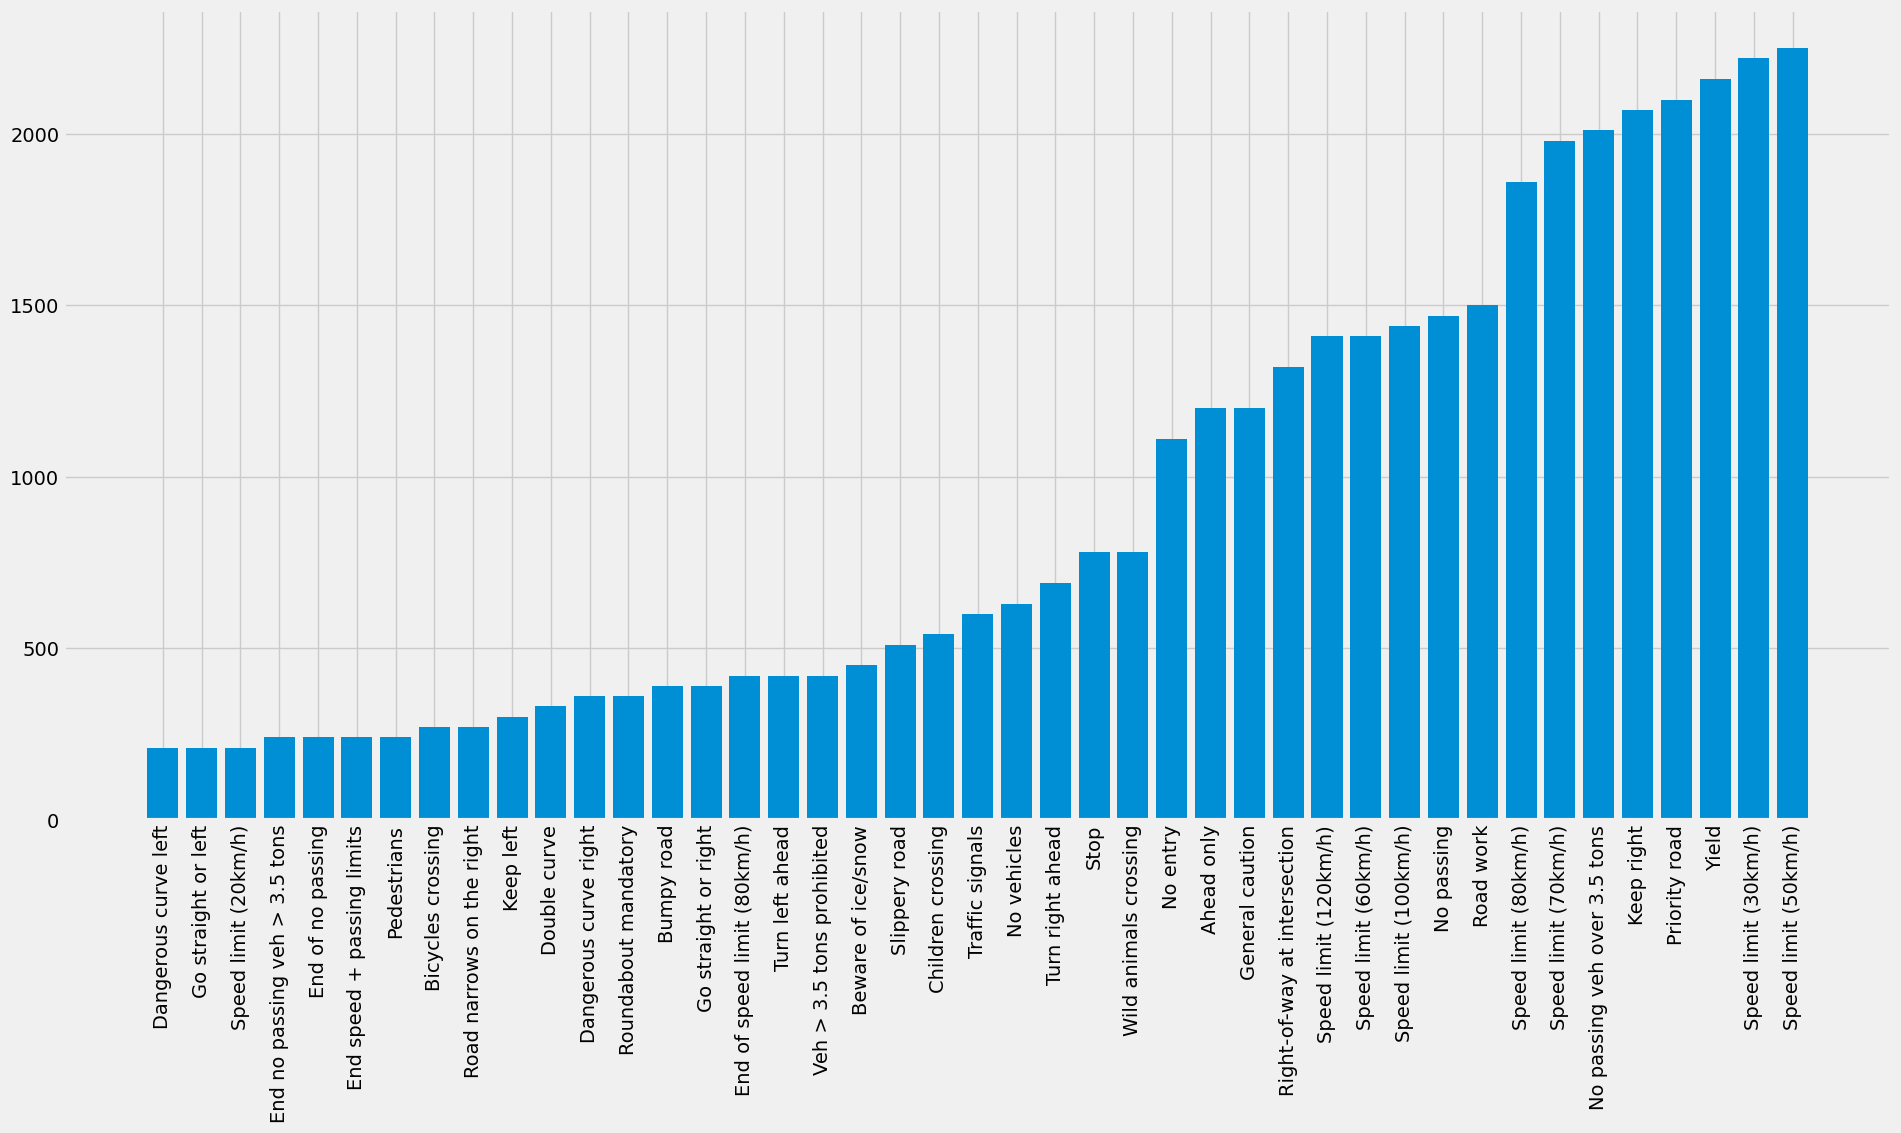

In [11]:
folders = os.listdir('/content/train') #os.listdir() 매써드는 지정한 디렉토리 내의 모든 파일과 디렉토리 리스트(list)를 리턴

train_num = []
class_num = []

for folder in folders:
  train_files = os.listdir(str(train_path) + '/'+ folder) #리스트로 가져오면 에러떠서 str로 변환해줌
  train_num.append(len(train_files))
  class_num.append(classes[int(folder)])

# 각각의 클래스의 이미지의 수에 기초해 데이터셋 분류하기
zipped_lists =  zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples =  zip(*sorted_pairs) # sorted(정렬할 데이터), 새로운 정렬된 리스트로 만들어서 반환
train_num, class_num = [ list(tuple) for tuple in tuples]

# 시각화
plt.figure(figsize = (21, 10))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [12]:
def load_data(data_dir):
    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=(30, 30))
            image = img_to_array(img) # 이미지를 넘파이 배열로 변환
            images.append(image)
            labels.append(category)

    return images, labels

images, labels = load_data(train_path)

# labels에 원핫 인코딩 진행
labels = to_categorical(labels)

# 트레인, 테스트 셋 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.4)

In [13]:
model = Sequential()

IMG_HEIGHT = 30
IMG_WIDTH = 30

# 첫번째 Convolutional Layer : 입력 데이터로부터 특징을 추출
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# 두번째 Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25)) # 인풋데이터의 25%를 무작위로 0으로 만듦

# 세번째 Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu')) # 특징을 추출하는 기능을 하는 필터, 비선형 값으로 바꿔주는 activation 함수->relu

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [14]:
# Flattening the layer and adding Dense Layer
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [19]:
# 모델 컴파일 하기
model.compile(
    loss='categorical_crossentropy', # 다중분류의 로스 함수
    optimizer='adam',
    metrics=['accuracy']
)

# 모델 핏하기
EPOCHS = 200
history = model.fit(x_train,
                    y_train,
                    validation_data = (x_test, y_test),
                    epochs=EPOCHS,
                    steps_per_epoch=60
                   )

Epoch 1/200
60/60 [==============================] - 43s 635ms/step - loss: 0.1700 - accuracy: 0.9485 - val_loss: 0.1024 - val_accuracy: 0.9753
Epoch 2/200
60/60 [==============================] - 39s 641ms/step - loss: 0.1541 - accuracy: 0.9540 - val_loss: 0.1013 - val_accuracy: 0.9745
Epoch 3/200
60/60 [==============================] - 38s 641ms/step - loss: 0.1357 - accuracy: 0.9585 - val_loss: 0.1040 - val_accuracy: 0.9737
Epoch 4/200
60/60 [==============================] - 47s 796ms/step - loss: 0.1227 - accuracy: 0.9628 - val_loss: 0.1007 - val_accuracy: 0.9761
Epoch 5/200
60/60 [==============================] - 38s 643ms/step - loss: 0.1239 - accuracy: 0.9649 - val_loss: 0.0911 - val_accuracy: 0.9789
Epoch 6/200
60/60 [==============================] - 39s 646ms/step - loss: 0.1057 - accuracy: 0.9666 - val_loss: 0.0864 - val_accuracy: 0.9793
Epoch 7/200
60/60 [==============================] - 39s 647ms/step - loss: 0.1071 - accuracy: 0.9685 - val_loss: 0.0876 - val_accuracy:

KeyboardInterrupt: 

In [20]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 8s 17ms/step - loss: 0.0793 - accuracy: 0.9890
test set accuracy:  98.90334010124207


In [21]:
Y_test = pd.read_csv('/content/Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

a =  pathlib.Path('/content/')

output = list()
for img in test_images:
    image = load_img(os.path.join(a, img), target_size=(30, 30))
    output.append(np.array(image))

X_test=np.array(output)
y_prob = model.predict(X_test)
pred = y_prob.argmax(axis=-1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 8s 19ms/step
Test Data accuracy:  93.50752177355503


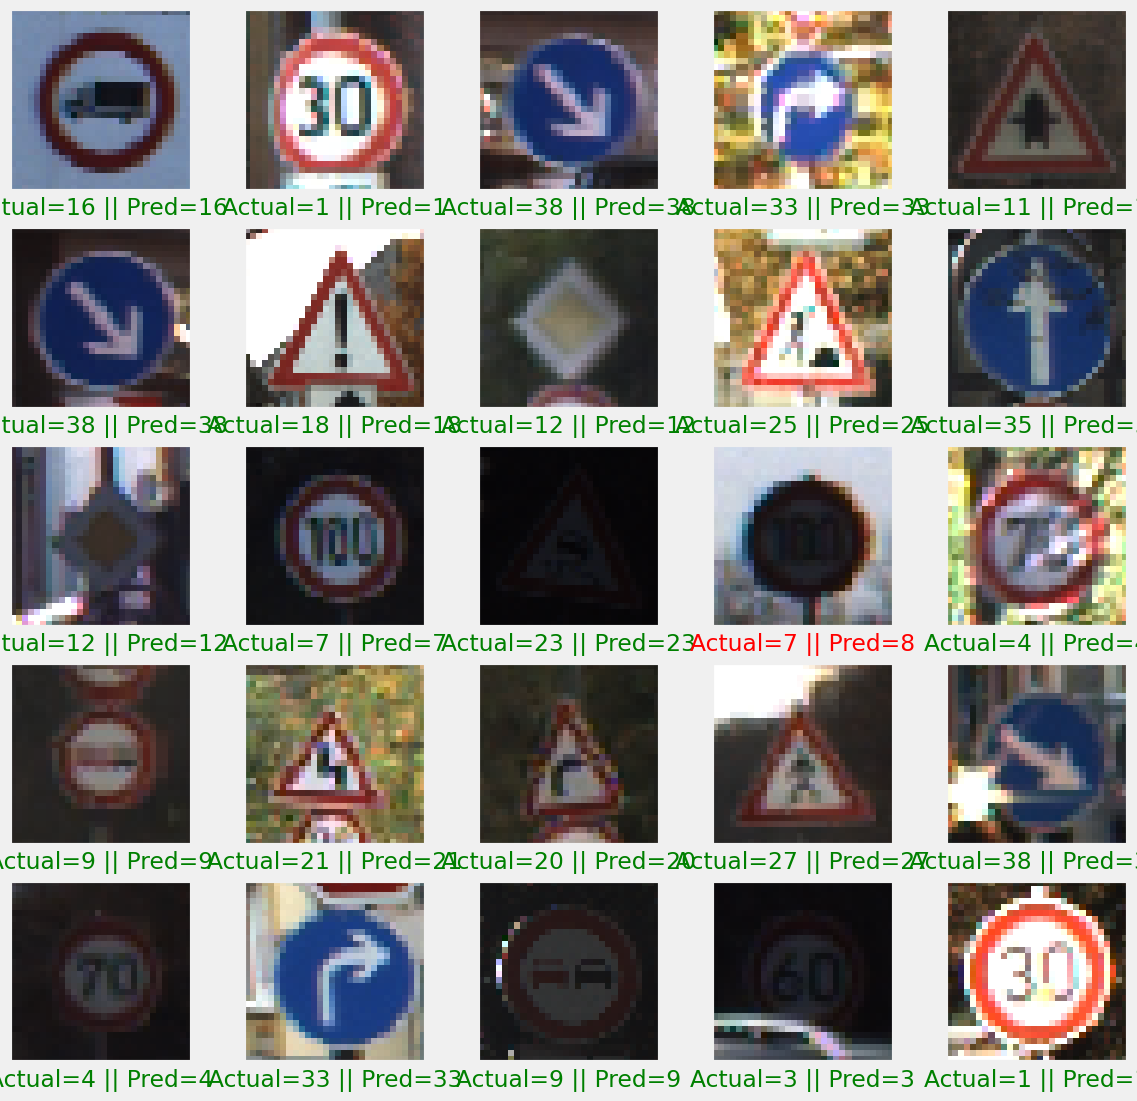

In [22]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()